In [1]:
# Import libraries
%load_ext autoreload
%autoreload 2

import sys
import os

# Get the parent directory (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Now you can import from config
from config import config

# Use functions inside config.py like:
# config.your_function()

In [2]:
config.AZURE_OPENAI

{'endpoint': 'https://your-endpoint.openai.azure.com/',
 'api_key': 'your-azure-openai-api-key',
 'deployment_name': 'your-gpt-deployment'}

In [3]:
from clients.azure_openai_client import *

# Initialize the mock client
# mock_client = MockAzureClient()
azure_client = get_azure_client(use_mock=True)

# Call get_response without specifying model_name
response1 = azure_client.get_response(prompt="Explain the risk score.")
print("Response 1:\n", response1)

# Call get_response with a model_name containing "judge"
response2 = azure_client.get_response(
    prompt="Evaluate explanation clarity.",
    model_name="RiskJudgeModel-v1"
)
print("\nResponse 2:\n", response2)

🧪 Mock Azure Client initialized. No actual API calls will be made.
Response 1:
 This entity has a high risk score of 85% primarily due to three factors: a high number of inbound wires, significant exposure to high-risk countries, and a central position in transaction networks. Each of these increases the risk profile significantly.

Response 2:
 Clarity: 1/5
Conciseness: 5/5
Completeness: 5/5
This explanation is generally clear and well-structured, with room for improvement.


In [4]:
from workflows import generate_data as gd

In [5]:
feature_lib = gd.create_realistic_aml_feature_library()

input_data_path = "../data/input/structured_aml_dataset.json"
df_structured = gd.generate_structured_shap_dataset(feature_lib, n_entities=100, output_path=input_data_path)

✅ Structured dataset saved to ../data/input/structured_aml_dataset.json


In [6]:
feature_lib

,feature_name,description
0,wirein_ct,Number of wire inbound transactions
1,wireout_ct,Number of wire outbound transactions
2,wirein_amt,Total inbound wire amount
3,wireout_amt,Total outbound wire amount
4,avg_txn_amt,Average transaction amount
5,high_risk_country_txn_pct,Percentage of transactions with high-risk coun...
6,acct_age_days,Account age in days
7,num_sar_reports,Number of SAR reports filed
8,login_freq_30d,Login frequency in the past 30 days
9,geo_diversity_score,Number of unique countries accessed from


In [7]:
df_structured

,entity_id,risk_score,features
0,1,0.014385,"{'wirein_ct': {'feature_value': 10, 'shap_valu..."
1,2,0.066226,"{'wirein_ct': {'feature_value': 10, 'shap_valu..."
2,3,0.009959,"{'wirein_ct': {'feature_value': 8, 'shap_value..."
3,4,0.293621,"{'wirein_ct': {'feature_value': 9, 'shap_value..."
4,5,0.245349,"{'wirein_ct': {'feature_value': 7, 'shap_value..."
...,...,...,...
95,96,0.337079,"{'wirein_ct': {'feature_value': 6, 'shap_value..."
96,97,0.109995,"{'wirein_ct': {'feature_value': 13, 'shap_valu..."
97,98,0.323244,"{'wirein_ct': {'feature_value': 8, 'shap_value..."
98,99,0.010753,"{'wirein_ct': {'feature_value': 9, 'shap_value..."


In [8]:
df_structured.iloc[0].features

{'wirein_ct': {'feature_value': 10,
  'shap_value': 0.016045618736948455,
  'abs_shap_value': 0.016045618736948455,
  'contribution_pct': 2.4623206951802605},
 'wireout_ct': {'feature_value': 10,
  'shap_value': -0.03592468373138248,
  'abs_shap_value': 0.03592468373138248,
  'contribution_pct': 5.5129125071316265},
 'wirein_amt': {'feature_value': 73833.07,
  'shap_value': -0.11910709535294602,
  'abs_shap_value': 0.11910709535294602,
  'contribution_pct': 18.277878256886925},
 'wireout_amt': {'feature_value': 87757.56,
  'shap_value': -0.10045249699165675,
  'abs_shap_value': 0.10045249699165675,
  'contribution_pct': 15.415190045337537},
 'avg_txn_amt': {'feature_value': 48348.9,
  'shap_value': 0.11073455704681769,
  'abs_shap_value': 0.11073455704681769,
  'contribution_pct': 16.993049377406148},
 'high_risk_country_txn_pct': {'feature_value': 10,
  'shap_value': 0.012800129506852293,
  'abs_shap_value': 0.012800129506852293,
  'contribution_pct': 1.9642759997240207},
 'acct_age_d

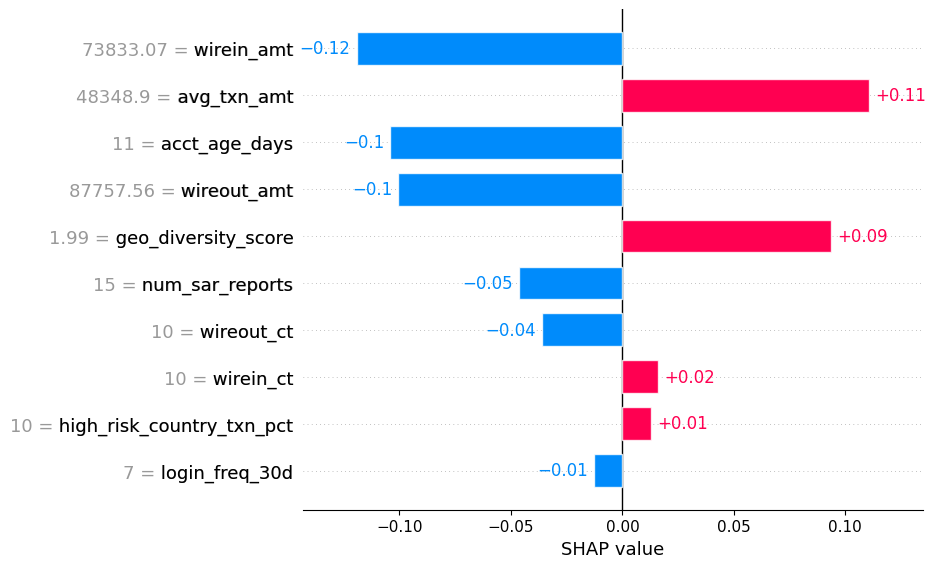

In [9]:
import shap

# Example: Plot for entity_id = 1

explanation = gd.load_shap_explanation(input_data_path, entity_id=1)
shap.plots.bar(explanation)

In [10]:
import json
import prompts.prompt_generator as pg

top_n = 10

with open(input_data_path, "r") as f:
    entity_data = json.loads(f.readline())  # Get first entity

feature_library_df = gd.create_realistic_aml_feature_library()
prompt = pg.build_feature_contribution_prompt_from_structured_json(entity_data, feature_library_df, top_n=top_n)
print(prompt)

You are a risk model explanation assistant. Given a risk score and a list of features with their descriptions and contributions, generate a clear, concise narrative explaining the risk score for entity ID 1.

Entity ID: 1
Risk Score: 1%
Top Features and Contributions:
- wirein_amt (Total inbound wire amount): 18.3% contribution
- avg_txn_amt (Average transaction amount): 17.0% contribution
- acct_age_days (Account age in days): 16.0% contribution
- wireout_amt (Total outbound wire amount): 15.4% contribution
- geo_diversity_score (Number of unique countries accessed from): 14.3% contribution
- num_sar_reports (Number of SAR reports filed): 7.1% contribution
- wireout_ct (Number of wire outbound transactions): 5.5% contribution
- wirein_ct (Number of wire inbound transactions): 2.5% contribution
- high_risk_country_txn_pct (Percentage of transactions with high-risk countries): 2.0% contribution
- login_freq_30d (Login frequency in the past 30 days): 1.9% contribution

Please produce a n

In [11]:
# Load structured dataset
with open(input_data_path, "r") as f:
    entity_data_list = [json.loads(line) for line in f]

In [ ]:
entity_data_list[0]

In [12]:
# Add prompt column
# df_with_prompts = gd.add_prompt_column(entity_data_list, feature_library_df, top_n=5)
df_with_prompts = gd.add_prompt_to_entity_json(entity_data_list, feature_library_df, top_n=top_n)
output_data_path = "../data/output/entities_with_prompts.json"
gd.save_entities_to_json(df_with_prompts, output_data_path)

✅ Entities saved to ../data/output/entities_with_prompts.json


In [ ]:
df_with_prompts[0]

In [13]:
# Load structured dataset
with open(output_data_path, "r") as f:
    entity_data_list = json.load(f)

In [14]:
entity_data_list[0]

{'entity_id': 1,
 'risk_score': 0.0143853163,
 'features': {'wirein_ct': {'feature_value': 10,
   'shap_value': 0.0160456187,
   'abs_shap_value': 0.0160456187,
   'contribution_pct': 2.4623206952},
  'wireout_ct': {'feature_value': 10,
   'shap_value': -0.0359246837,
   'abs_shap_value': 0.0359246837,
   'contribution_pct': 5.5129125071},
  'wirein_amt': {'feature_value': 73833.07,
   'shap_value': -0.1191070954,
   'abs_shap_value': 0.1191070954,
   'contribution_pct': 18.2778782569},
  'wireout_amt': {'feature_value': 87757.56,
   'shap_value': -0.100452497,
   'abs_shap_value': 0.100452497,
   'contribution_pct': 15.4151900453},
  'avg_txn_amt': {'feature_value': 48348.9,
   'shap_value': 0.110734557,
   'abs_shap_value': 0.110734557,
   'contribution_pct': 16.9930493774},
  'high_risk_country_txn_pct': {'feature_value': 10,
   'shap_value': 0.0128001295,
   'abs_shap_value': 0.0128001295,
   'contribution_pct': 1.9642759997},
  'acct_age_days': {'feature_value': 11,
   'shap_value

In [15]:
# output_data_path = "../data/output/entities_with_prompts.json"

gd.enrich_entities_with_llm_explanations(
    input_json_path="../data/output/entities_with_prompts.json",
    output_json_path="../data/output/entities_with_llm_explanations.json",
    feature_library_df=feature_library_df,
    azure_client=azure_client,
    top_n=top_n,
    log_every_n=25# New parameter for logging frequency
)

Processed entity 25/100
Processed entity 50/100
Processed entity 75/100
Processed entity 100/100
✅ Saved enriched entities with explanations to ../data/output/entities_with_llm_explanations.json


In [16]:
with open("../data/output/entities_with_llm_explanations.json", "r") as f:
    output = json.load(f)

In [17]:
output[0]

{'entity_id': 1,
 'risk_score': 0.0143853163,
 'features': {'wirein_ct': {'feature_value': 10,
   'shap_value': 0.0160456187,
   'abs_shap_value': 0.0160456187,
   'contribution_pct': 2.4623206952},
  'wireout_ct': {'feature_value': 10,
   'shap_value': -0.0359246837,
   'abs_shap_value': 0.0359246837,
   'contribution_pct': 5.5129125071},
  'wirein_amt': {'feature_value': 73833.07,
   'shap_value': -0.1191070954,
   'abs_shap_value': 0.1191070954,
   'contribution_pct': 18.2778782569},
  'wireout_amt': {'feature_value': 87757.56,
   'shap_value': -0.100452497,
   'abs_shap_value': 0.100452497,
   'contribution_pct': 15.4151900453},
  'avg_txn_amt': {'feature_value': 48348.9,
   'shap_value': 0.110734557,
   'abs_shap_value': 0.110734557,
   'contribution_pct': 16.9930493774},
  'high_risk_country_txn_pct': {'feature_value': 10,
   'shap_value': 0.0128001295,
   'abs_shap_value': 0.0128001295,
   'contribution_pct': 1.9642759997},
  'acct_age_days': {'feature_value': 11,
   'shap_value

In [18]:
from evaluation import judge

gd.enrich_and_evaluate_entities(
    input_json_path="../data/output/entities_with_llm_explanations.json",
    output_json_path="../data/output/entities_enriched_evaluated.json",
    feature_library_df=feature_library_df,
    azure_client=azure_client,
    judge_models=judge.MOCK_JUDGE_MODELS,
    top_n=top_n,
    log_every_n=25  # print progress every 3 entities
)

✅ Processed 25/100 entities
✅ Processed 50/100 entities
✅ Processed 75/100 entities
✅ Processed 100/100 entities
✅ Evaluations completed and saved to ../data/output/entities_enriched_evaluated.json


In [19]:
with open("../data/output/entities_enriched_evaluated.json", "r") as f:
    output = json.load(f)

In [20]:
output[0]

{'entity_id': 1,
 'risk_score': 0.0143853163,
 'features': {'wirein_ct': {'feature_value': 10,
   'shap_value': 0.0160456187,
   'abs_shap_value': 0.0160456187,
   'contribution_pct': 2.4623206952},
  'wireout_ct': {'feature_value': 10,
   'shap_value': -0.0359246837,
   'abs_shap_value': 0.0359246837,
   'contribution_pct': 5.5129125071},
  'wirein_amt': {'feature_value': 73833.07,
   'shap_value': -0.1191070954,
   'abs_shap_value': 0.1191070954,
   'contribution_pct': 18.2778782569},
  'wireout_amt': {'feature_value': 87757.56,
   'shap_value': -0.100452497,
   'abs_shap_value': 0.100452497,
   'contribution_pct': 15.4151900453},
  'avg_txn_amt': {'feature_value': 48348.9,
   'shap_value': 0.110734557,
   'abs_shap_value': 0.110734557,
   'contribution_pct': 16.9930493774},
  'high_risk_country_txn_pct': {'feature_value': 10,
   'shap_value': 0.0128001295,
   'abs_shap_value': 0.0128001295,
   'contribution_pct': 1.9642759997},
  'acct_age_days': {'feature_value': 11,
   'shap_value

In [21]:
gd.update_mean_std_scores_in_json(
    input_json_path="../data/output/entities_enriched_evaluated.json",
    output_json_path="../data/output/entities_with_stats.json"
)

✅ Per-entity stats saved to: ../data/output/entities_with_stats.json


In [5]:
import json

with open("../data/output/entities_with_stats.json", "r") as f:
    output = json.load(f)

In [6]:
output[0]

{'entity_id': 1,
 'risk_score': 0.0143853163,
 'features': {'wirein_ct': {'feature_value': 10,
   'shap_value': 0.0160456187,
   'abs_shap_value': 0.0160456187,
   'contribution_pct': 2.4623206952},
  'wireout_ct': {'feature_value': 10,
   'shap_value': -0.0359246837,
   'abs_shap_value': 0.0359246837,
   'contribution_pct': 5.5129125071},
  'wirein_amt': {'feature_value': 73833.07,
   'shap_value': -0.1191070954,
   'abs_shap_value': 0.1191070954,
   'contribution_pct': 18.2778782569},
  'wireout_amt': {'feature_value': 87757.56,
   'shap_value': -0.100452497,
   'abs_shap_value': 0.100452497,
   'contribution_pct': 15.4151900453},
  'avg_txn_amt': {'feature_value': 48348.9,
   'shap_value': 0.110734557,
   'abs_shap_value': 0.110734557,
   'contribution_pct': 16.9930493774},
  'high_risk_country_txn_pct': {'feature_value': 10,
   'shap_value': 0.0128001295,
   'abs_shap_value': 0.0128001295,
   'contribution_pct': 1.9642759997},
  'acct_age_days': {'feature_value': 11,
   'shap_value

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_entity_quality(entity_data_list, threshold=4.0):
    """
    Plot per-entity evaluation means and highlight if narrative quality is good or not.
    """
    entity_ids = list(range(1, len(entity_data_list) + 1))
    clarity_means = [e["stats"]["Clarity"]["mean"] for e in entity_data_list]
    conciseness_means = [e["stats"]["Conciseness"]["mean"] for e in entity_data_list]
    completeness_means = [e["stats"]["Completeness"]["mean"] for e in entity_data_list]

    overall_scores = [
        np.mean([clarity, conciseness, completeness])
        for clarity, conciseness, completeness in zip(clarity_means, conciseness_means, completeness_means)
    ]

    qualities = [
        "Good" if score >= threshold else "Needs Improvement"
        for score in overall_scores
    ]

    colors = ["green" if q == "Good" else "red" for q in qualities]

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(entity_ids, overall_scores, color=colors)

    ax.axhline(y=threshold, color='black', linestyle='--', label=f'Threshold = {threshold}')
    ax.set_xlabel("Entity Index")
    ax.set_ylabel("Average Evaluation Score")
    ax.set_title("Narrative Quality per Entity")
    ax.set_ylim(0, 5.5)

    for i, bar in enumerate(bars):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'{overall_scores[i]:.2f}', ha='center', fontsize=8)

    ax.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.show()


In [ ]:
# Example usage
# plot_evaluation stats(input _data)
# gd.plot_evaluation_stats(output)

entity_data_list = output
plot_entity_quality(entity_data_list, threshold=4.0)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_entity_quality_separately(entity_data_list, threshold=4.0):
    """
    Plot Clarity, Conciseness, and Completeness scores per entity in three separate subplots.
    """
    entity_ids = list(range(1, len(entity_data_list) + 1))
    clarity_means = [e["stats"]["Clarity"]["mean"] for e in entity_data_list]
    conciseness_means = [e["stats"]["Conciseness"]["mean"] for e in entity_data_list]
    completeness_means = [e["stats"]["Completeness"]["mean"] for e in entity_data_list]

    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    # Common x
    x = np.arange(len(entity_ids))

    # Plot Clarity
    axes[0].bar(x, clarity_means, color='skyblue')
    axes[0].axhline(threshold, color='black', linestyle='--', label=f'Threshold = {threshold}')
    axes[0].set_title("Clarity Scores per Entity")
    axes[0].set_ylabel("Score")
    axes[0].set_ylim(0, 5.5)
    axes[0].legend()
    axes[0].grid(True, axis='y', linestyle='--', alpha=0.6)

    # Plot Conciseness
    axes[1].bar(x, conciseness_means, color='lightgreen')
    axes[1].axhline(threshold, color='black', linestyle='--')
    axes[1].set_title("Conciseness Scores per Entity")
    axes[1].set_ylabel("Score")
    axes[1].set_ylim(0, 5.5)
    axes[1].grid(True, axis='y', linestyle='--', alpha=0.6)

    # Plot Completeness
    axes[2].bar(x, completeness_means, color='salmon')
    axes[2].axhline(threshold, color='black', linestyle='--')
    axes[2].set_title("Completeness Scores per Entity")
    axes[2].set_xlabel("Entity Index")
    axes[2].set_ylabel("Score")
    axes[2].set_ylim(0, 5.5)
    axes[2].grid(True, axis='y', linestyle='--', alpha=0.6)

    # Set x-ticks
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(entity_ids)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_entity_quality_separately(output, threshold=4.0)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_entity_quality_stats(entity_data_list, threshold=4.0):
    """
    Plot Clarity, Conciseness, and Completeness scores per entity in three subplots
    showing both mean and standard deviation (error bars).
    """
    entity_ids = list(range(1, len(entity_data_list) + 1))

    clarity_means = [e["stats"]["Clarity"]["mean"] for e in entity_data_list]
    clarity_stds = [e["stats"]["Clarity"]["std"] for e in entity_data_list]
    
    conciseness_means = [e["stats"]["Conciseness"]["mean"] for e in entity_data_list]
    conciseness_stds = [e["stats"]["Conciseness"]["std"] for e in entity_data_list]

    completeness_means = [e["stats"]["Completeness"]["mean"] for e in entity_data_list]
    completeness_stds = [e["stats"]["Completeness"]["std"] for e in entity_data_list]

    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    x = np.arange(len(entity_ids))

    # Plot Clarity
    axes[0].bar(x, clarity_means, yerr=clarity_stds, capsize=5, color='skyblue')
    axes[0].axhline(threshold, color='black', linestyle='--', label=f'Threshold = {threshold}')
    axes[0].set_title("Clarity Scores (Mean ± Std)")
    axes[0].set_ylabel("Score")
    axes[0].set_ylim(0, 5.5)
    axes[0].legend()
    axes[0].grid(True, axis='y', linestyle='--', alpha=0.6)

    # Plot Conciseness
    axes[1].bar(x, conciseness_means, yerr=conciseness_stds, capsize=5, color='lightgreen')
    axes[1].axhline(threshold, color='black', linestyle='--')
    axes[1].set_title("Conciseness Scores (Mean ± Std)")
    axes[1].set_ylabel("Score")
    axes[1].set_ylim(0, 5.5)
    axes[1].grid(True, axis='y', linestyle='--', alpha=0.6)

    # Plot Completeness
    axes[2].bar(x, completeness_means, yerr=completeness_stds, capsize=5, color='salmon')
    axes[2].axhline(threshold, color='black', linestyle='--')
    axes[2].set_title("Completeness Scores (Mean ± Std)")
    axes[2].set_xlabel("Entity Index")
    axes[2].set_ylabel("Score")
    axes[2].set_ylim(0, 5.5)
    axes[2].grid(True, axis='y', linestyle='--', alpha=0.6)

    axes[2].set_xticks(x)
    axes[2].set_xticklabels(entity_ids)

    plt.tight_layout()
    plt.show()


In [ ]:
plot_entity_quality_stats(output, threshold=4.0)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_entity_quality_stats_business(entity_data_list, threshold=4.0):
    entity_ids = list(range(1, len(entity_data_list) + 1))
    clarity_means = [e["stats"]["Clarity"]["mean"] for e in entity_data_list]
    clarity_stds = [e["stats"]["Clarity"]["std"] for e in entity_data_list]
    
    conciseness_means = [e["stats"]["Conciseness"]["mean"] for e in entity_data_list]
    conciseness_stds = [e["stats"]["Conciseness"]["std"] for e in entity_data_list]

    completeness_means = [e["stats"]["Completeness"]["mean"] for e in entity_data_list]
    completeness_stds = [e["stats"]["Completeness"]["std"] for e in entity_data_list]

    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

    x = np.arange(len(entity_ids))

    # Define a helper to plot each metric
    def plot_metric(ax, means, stds, color, title):
        ax.bar(x, means, yerr=stds, capsize=5, color=color, alpha=0.75)
        ax.axhline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {threshold}')
        ax.set_ylim(0, 5.5)
        ax.set_ylabel("Score (1-5 scale)", fontsize=11)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        ax.legend(loc='upper right')
        # Highlight bars below threshold
        for i, (mean_score) in enumerate(means):
            if mean_score < threshold:
                ax.get_children()[i].set_color('orange')

    plot_metric(axes[0], clarity_means, clarity_stds, 'skyblue', "Clarity Scores (Mean ± Std Dev)")
    plot_metric(axes[1], conciseness_means, conciseness_stds, 'lightgreen', "Conciseness Scores (Mean ± Std Dev)")
    plot_metric(axes[2], completeness_means, completeness_stds, 'salmon', "Completeness Scores (Mean ± Std Dev)")

    axes[2].set_xlabel("Entity Number", fontsize=12)
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(entity_ids, rotation=45, ha='right')

    fig.suptitle("Narrative Quality Evaluation Across Entities\n(Mean Scores with Standard Deviation Error Bars)", fontsize=16, fontweight='bold', y=0.95)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


In [ ]:
plot_entity_quality_stats_business(output, threshold=4.0)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.patches import Patch

# def plot_entity_quality_stats_business(entity_data_list, threshold=4.0, save_path=None):
#     entity_ids = list(range(1, len(entity_data_list) + 1))
#     clarity_means = [e["stats"]["Clarity"]["mean"] for e in entity_data_list]
#     clarity_stds = [e["stats"]["Clarity"]["std"] for e in entity_data_list]
    
#     conciseness_means = [e["stats"]["Conciseness"]["mean"] for e in entity_data_list]
#     conciseness_stds = [e["stats"]["Conciseness"]["std"] for e in entity_data_list]

#     completeness_means = [e["stats"]["Completeness"]["mean"] for e in entity_data_list]
#     completeness_stds = [e["stats"]["Completeness"]["std"] for e in entity_data_list]

#     fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

#     x = np.arange(len(entity_ids))

#     def plot_metric(ax, means, stds, color, title):
#         bars = ax.bar(x, means, yerr=stds, capsize=5, color=color, alpha=0.75)
#         ax.axhline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {threshold}')
#         ax.set_ylim(0, 5.5)
#         ax.set_ylabel("Score (1-5 scale)", fontsize=11)
#         ax.set_title(title, fontsize=14, fontweight='bold')
#         ax.grid(axis='y', linestyle='--', alpha=0.5)
#         ax.legend(loc='upper right')
#         for i, mean_score in enumerate(means):
#             if mean_score < threshold:
#                 bars[i].set_color('red')

#     plot_metric(axes[0], clarity_means, clarity_stds, 'dodgerblue', "Clarity Scores (Mean ± Std Dev)")
#     plot_metric(axes[1], conciseness_means, conciseness_stds, 'mediumseagreen', "Conciseness Scores (Mean ± Std Dev)")
#     plot_metric(axes[2], completeness_means, completeness_stds, 'darkorange', "Completeness Scores (Mean ± Std Dev)")

#     axes[2].set_xlabel("Entity Number", fontsize=12)
#     axes[2].set_xticks(x)
#     axes[2].set_xticklabels(entity_ids, rotation=45, ha='right')

#     fig.suptitle("Narrative Quality Evaluation Across Entities\n(Mean Scores with Standard Deviation Error Bars)", fontsize=16, fontweight='bold', y=0.95)

#     # Legend for color meanings
#     legend_elements = [
#         Patch(facecolor='dodgerblue', edgecolor='black', label='Clarity Score ≥ Threshold'),
#         Patch(facecolor='mediumseagreen', edgecolor='black', label='Conciseness Score ≥ Threshold'),
#         Patch(facecolor='darkorange', edgecolor='black', label='Completeness Score ≥ Threshold'),
#         Patch(facecolor='red', edgecolor='black', label='Score < Threshold'),
#         Patch(facecolor='none', edgecolor='red', linestyle='--', label='Threshold Line')
#     ]

#     fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=11, frameon=False)

#     plt.tight_layout(rect=[0, 0.07, 1, 0.93])

#     if save_path:
#         plt.savefig(save_path, dpi=300)
#         print(f"Figure saved to: {save_path}")
    
#     plt.show()

Figure saved to: ../data/output/evaluation_scores.png


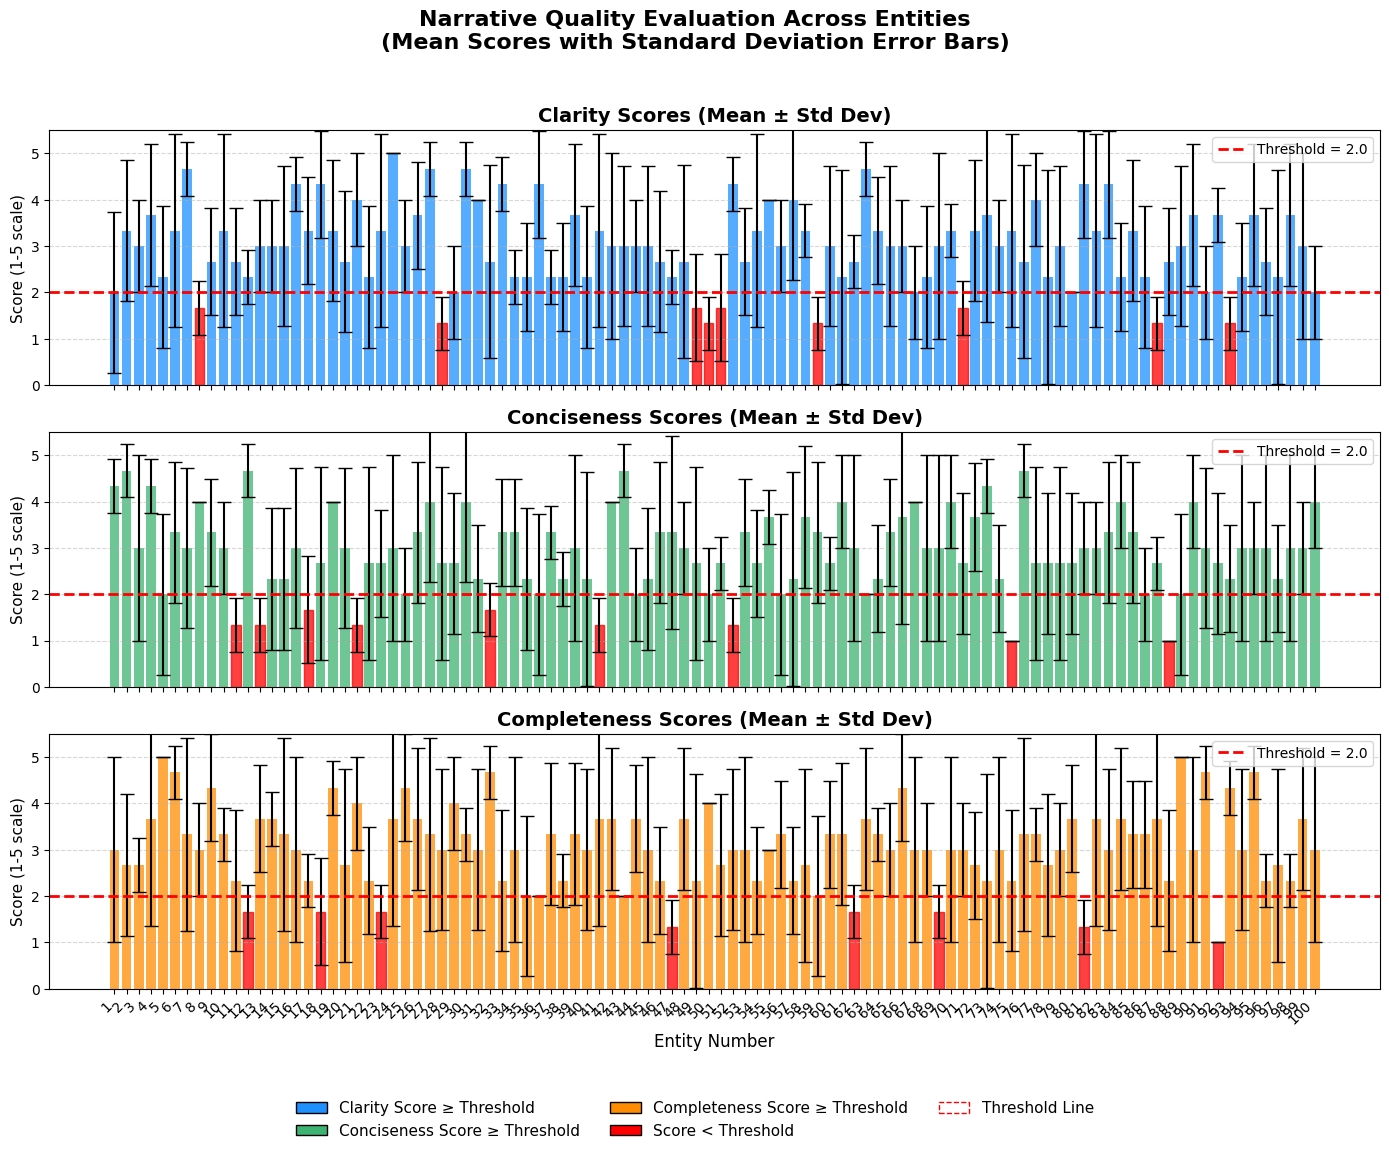

In [7]:
threshold = 2.0

gd.plot_entity_quality_stats_business(output, threshold=threshold, save_path="../data/output/evaluation_scores.png")

In [8]:
# def get_entities_below_threshold(entity_data_list, threshold=4.0):
#     below_threshold_entities = []

#     for i, entity in enumerate(entity_data_list, start=1):
#         clarity = entity["stats"]["Clarity"]["mean"]
#         conciseness = entity["stats"]["Conciseness"]["mean"]
#         completeness = entity["stats"]["Completeness"]["mean"]

#         if (clarity is not None and clarity < threshold) or \
#            (conciseness is not None and conciseness < threshold) or \
#            (completeness is not None and completeness < threshold):
#             below_threshold_entities.append(i)  # or entity ID if you have one

#     return below_threshold_entities

# Example usage:
below_thresh_ids = gd.get_entities_below_threshold(output, threshold=threshold)
print("Entities below threshold:", below_thresh_ids)

Entities below threshold: [8, 11, 12, 13, 17, 18, 21, 23, 28, 32, 41, 47, 49, 50, 51, 52, 59, 62, 69, 71, 75, 81, 87, 88, 92, 93]


In [9]:
len(below_thresh_ids)

26

Figure saved to: ../data/output/evaluation_scores_2.png


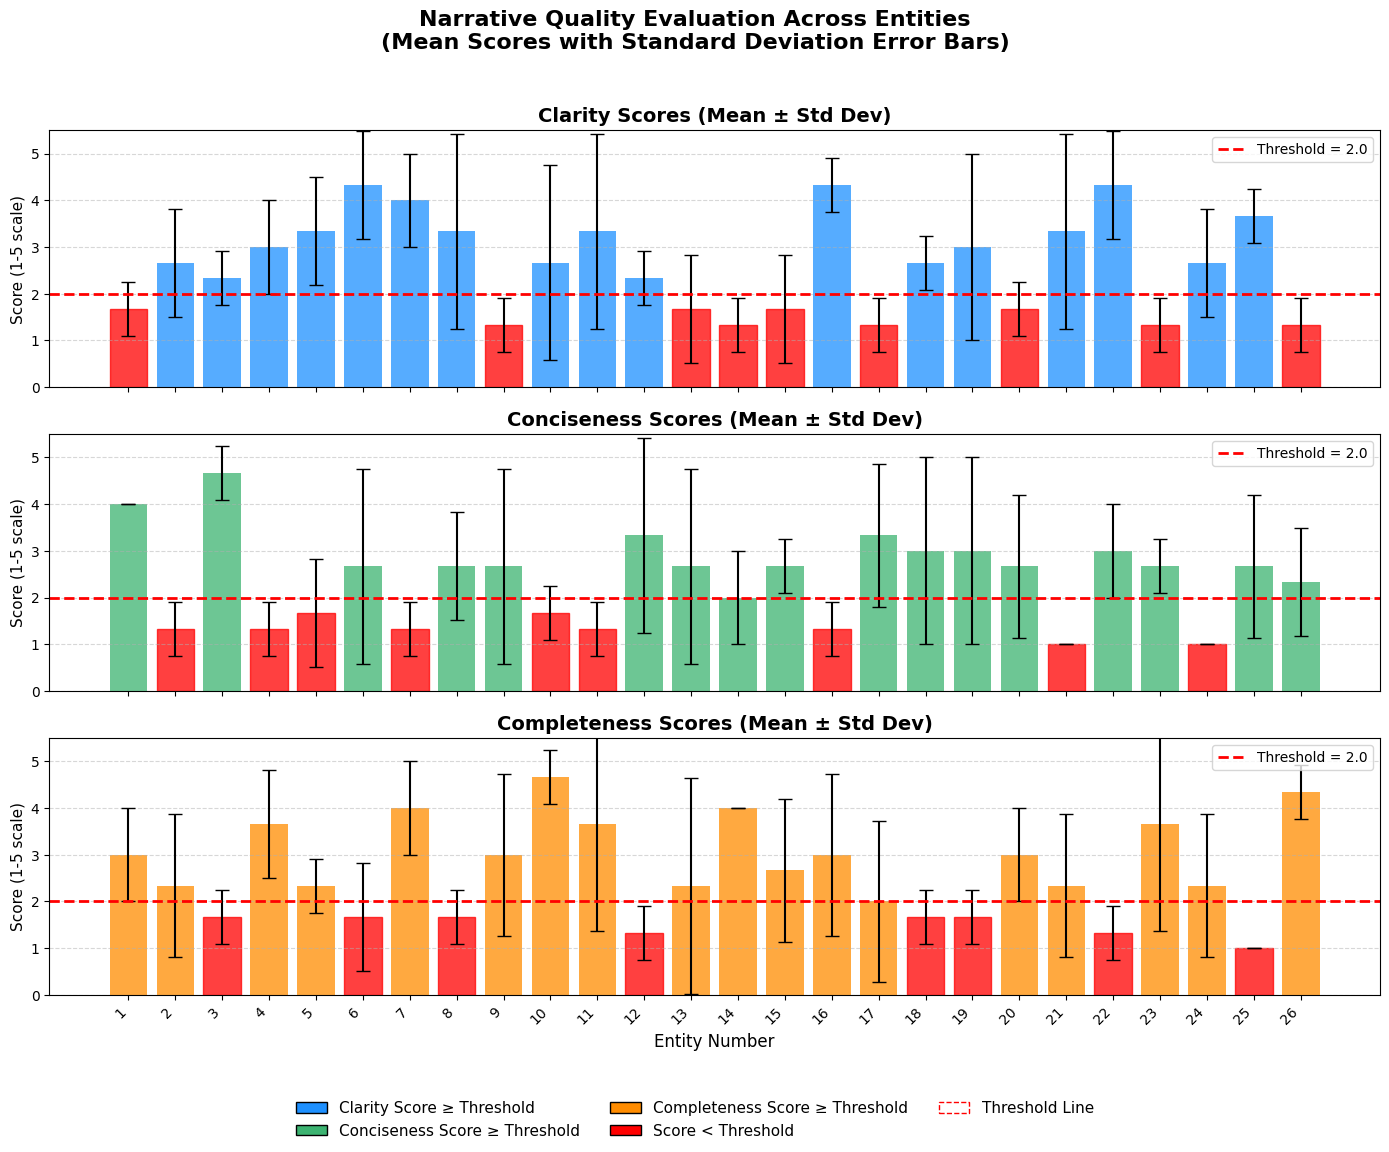

In [10]:
# Sample list of entity IDs to keep
target_ids = below_thresh_ids  # replace with your actual list

# Filtered data
filtered_data = [entity for entity in output if entity['entity_id'] in target_ids]

gd.plot_entity_quality_stats_business(filtered_data, threshold=threshold, save_path="../data/output/evaluation_scores_2.png")

In [11]:
target_ids

[8,
 11,
 12,
 13,
 17,
 18,
 21,
 23,
 28,
 32,
 41,
 47,
 49,
 50,
 51,
 52,
 59,
 62,
 69,
 71,
 75,
 81,
 87,
 88,
 92,
 93]

In [12]:
# entity IDs you want to plot
selected_ids = [8]

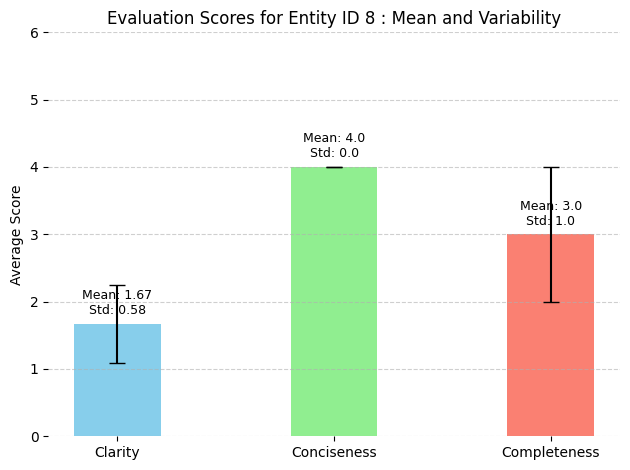

In [13]:
# call the function
gd.plot_evaluation_stats(filtered_data, selected_ids)